In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [37]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset
from scripts.utils import train_keys, target_keys

In [38]:
full_test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data.pkl"
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/QLKNN_test_data.pkl"

df_full_test = pd.read_pickle(full_test)
target = df_full_test['Target']
df_full_test = df_full_test[train_keys]

df_test = pd.read_pickle(test)
df_test = df_test[train_keys]

n = 50_000

## Model 1 - AE trained on inputs that give outputs

In [39]:
path = "/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-1/Run-1/experiment_name=0-epoch=24-val_loss=0.30.ckpt"

model = AutoEncoder.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 100, learning_rate = 0.002)
encoder = model.encoder

### Evaluate on inputs that give outputs

In [40]:
data_test = torch.from_numpy(df_test.values).float()
outputs_test = encoder.forward(data_test).detach().numpy()

<IPython.core.display.Javascript object>


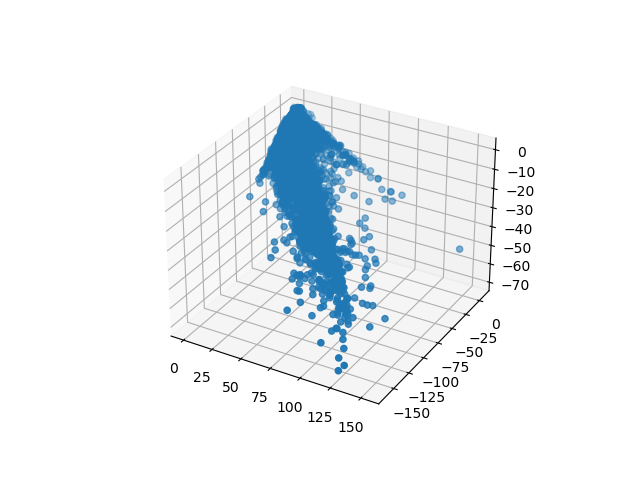

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_test[:n,0], outputs_test[:n,1],outputs_test[:n,2])
fig.show()

<IPython.core.display.Javascript object>


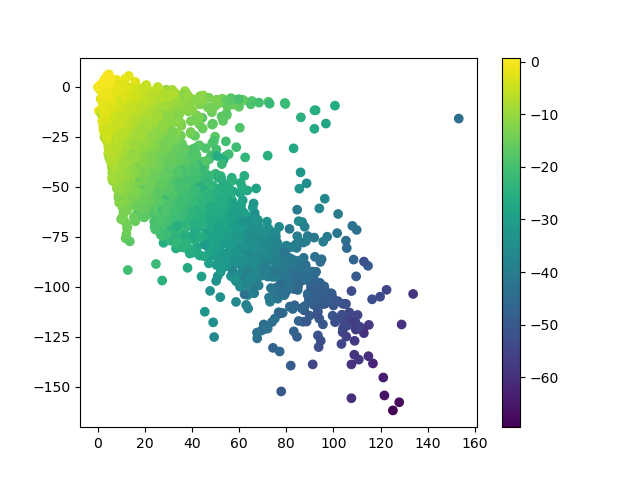

In [42]:
plt.figure()

sc = plt.scatter(outputs_test[:n,0], outputs_test[:n,1], c = outputs_test[:n,2])
plt.colorbar(sc)
plt.show()

### Evaluate on all inputs

In [43]:
data_test_full = torch.from_numpy(df_full_test.values).float()
outputs_test_full = encoder.forward(data_test_full).detach().numpy()

<IPython.core.display.Javascript object>


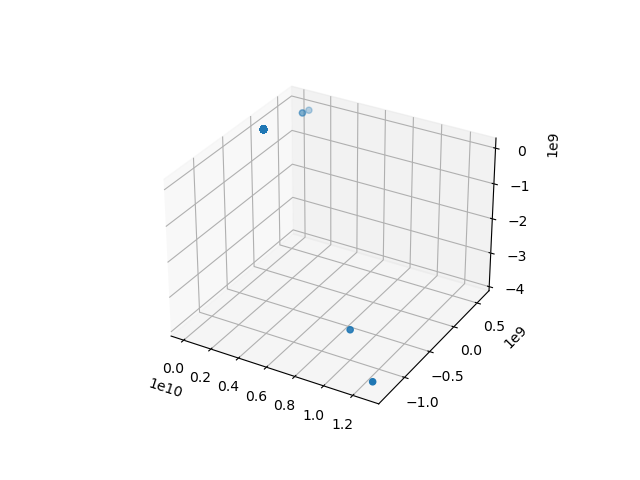

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1],outputs_test_full[:n,2])
fig.show()

<IPython.core.display.Javascript object>


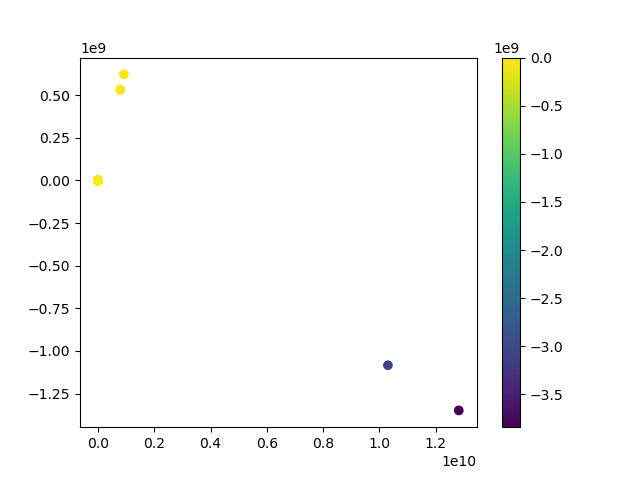

In [45]:
plt.figure()
sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
plt.colorbar(sc)
plt.show()

## Model 2 - AE trained on all inputs

In [46]:
path = "/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-1/Run-1/experiment_name=0-epoch=24-val_loss=0.30.ckpt"

model_full = AutoEncoder.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 100, learning_rate = 0.002)
encoder_full = model_full.encoder

### Evaluate on inputs that give outputs

In [47]:
outputs_encoder_full_test = encoder_full.forward(data_test).detach().numpy()

<IPython.core.display.Javascript object>


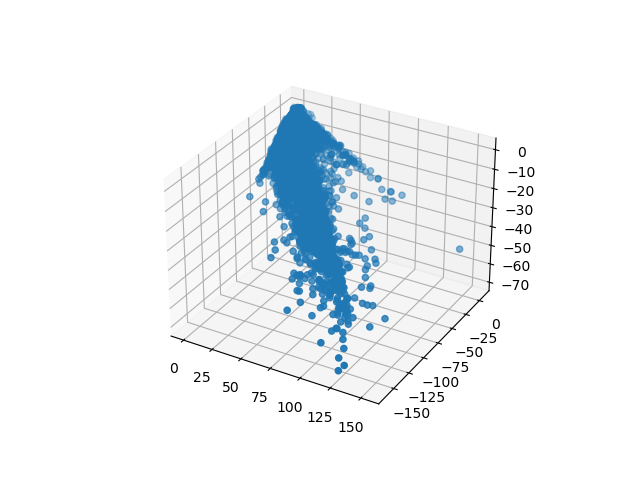

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_encoder_full_test[:n,0], outputs_encoder_full_test[:n,1],
           outputs_encoder_full_test[:n,2])
fig.show()

### Evaluate on all inputs

In [60]:
outputs_encoder_full_test_full = encoder_full.forward(data_test_full).detach().numpy()

<IPython.core.display.Javascript object>


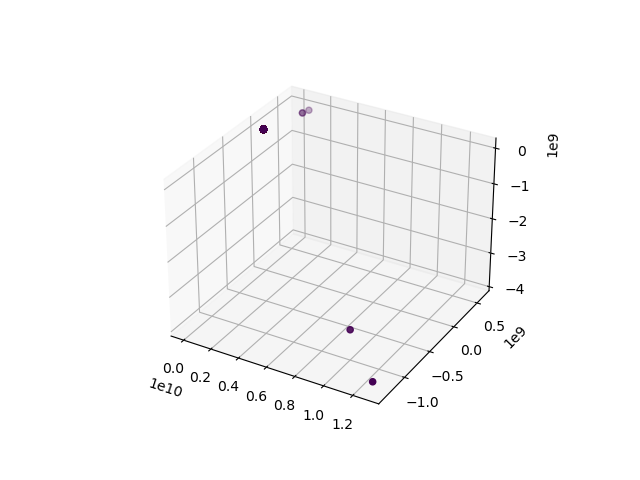

In [61]:
fig = plt.figure()
# n = 100_000
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_encoder_full_test_full[:n,0], outputs_encoder_full_test_full[:n,1],
           outputs_encoder_full_test_full[:n,2], c = target[:n])

fig.show()